In [40]:
# import librairies
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from numpy import linalg as LA
import scipy.stats 
from scipy.stats import norm

In [41]:
n=2 # the dimension of data
N1=1000 # the number of observations for first class
N2=1000 # the number of observations for second class
kappa=10 # degree of concentration
true_mean1=np.array([np.sqrt(2)/2, np.sqrt(2)/2]) # the true first mean on the sphere
true_mean2=np.array([-np.sqrt(2)/2, np.sqrt(2)/2]) # the true second mean on the sphere

In [42]:
# Simulate spherical data from the von Mises-Fisher distribution
z1=np.zeros([N1,n])
z2=np.zeros([N2,n])

for i in range(N1):
    z1[i,:]=np.random.vonmises(true_mean1, kappa).T
    z1[i,:]=z1[i,:]/LA.norm(z1[i,:]) # normalize data for consistency
    
for i in range(N2):
    z2[i,:]=np.random.vonmises(true_mean2, kappa).T
    z2[i,:]=z2[i,:]/LA.norm(z2[i,:]) # normalize data for consistency

In [43]:
# geometric tools on the sphere S^{n-1}
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.hypersphere import Hypersphere
sphere = Hypersphere(dim=n-1)

In [44]:
# find the Fréchet mean estimates
Fmean1 = FrechetMean(metric=sphere.metric)
Fmean1.fit(z1)
estimate_mean1=Fmean1.estimate_.reshape((n, 1))

Fmean2 = FrechetMean(metric=sphere.metric)
Fmean2.fit(z2)
estimate_mean2=Fmean2.estimate_.reshape((n, 1))

In [45]:
# project data into the tangent space of the sphere at true_mean1 and true_mean2
x1=np.zeros([N1,n])
x2=np.zeros([N2,n])

for i in range(N1):
    x1[i,:]=z1[i,:]/np.inner(np.array(z1[i,:]),true_mean1.T)
    
for i in range(N2):    
    x2[i,:]=z2[i,:]/np.inner(np.array(z2[i,:]),true_mean2.T)    

In [46]:
# evaluate the two resultants
SN1=np.sum([x1],1).T
SN2=np.sum([x2],1).T

In [47]:
# estimate the mean and std of concentrations: E(c^j) and \sqrt{Var(c^j)}; j=1,2
inner_product1=np.zeros([N1,1])
inner_product2=np.zeros([N2,1])

for i in range(N1):
    inner_product1[i]=np.inner(np.array(z1[i,:]),estimate_mean1.T)
    
for i in range(N2):    
    inner_product2[i]=np.inner(np.array(z2[i,:]),estimate_mean2.T)
   

mean_c1=LA.norm(SN1)/(N1*LA.norm(np.mean([z1],1)));    
mean_c2=LA.norm(SN2)/(N2*LA.norm(np.mean([z2],1)));    
    
std_c1=np.sqrt(np.mean(1./inner_product1**2) - mean_c1**2)    
std_c2=np.sqrt(np.mean(1./inner_product2**2) - mean_c2**2)    

In [48]:
# all possible p-values with a precision of 0.01 in this example
p=np.linspace(0,1,101)

In [49]:
# find the quantile of standard normal distribution
q = scipy.stats.norm.ppf(1-p/2)
# estimate sigma_j^2 for j=1,2
mat1=np.zeros([n,n])
mat2=np.zeros([n,n])

for i in range(N1):
    mat1+=np.dot(z1[i,:].reshape((n, 1)), z1[i,:].reshape((1, n)))
    
for i in range(N2):    
    mat2+=np.dot(z2[i,:].reshape((n, 1)), z2[i,:].reshape((1, n)))
    
sigma2_1=(std_c1**2)*np.dot(np.dot(np.mean([z1],1).reshape((1,n)),mat1),np.mean([z1],1).reshape((n,1)))/N1
sigma2_2=(std_c2**2)*np.dot(np.dot(np.mean([z2],1).reshape((1,n)),mat2),np.mean([z2],1).reshape((n,1)))/N2

# find the threshold
threshold=(q*np.sqrt(sigma2_1/N1+sigma2_2/N2)).reshape((np.shape(p)[0],1))

In [50]:
# the statistic value
T1 = LA.norm(np.mean([z1], 1)) * LA.norm(SN1) / N1 
T2 = LA.norm(np.mean([z2], 1)) * LA.norm(SN2) / N2 
T=T1-T2

M = np.zeros([threshold.shape[0], 1]) 

for i in range(threshold.shape[0]):
    if np.any(T >= threshold[i]) or np.any(T <= -threshold[i]):
        M[i] = 1
    else:
        M[i] = 0

# find the p-value        
p_value=p[list(np.array(M) == 1).index(True)]
print(p_value)

0.59


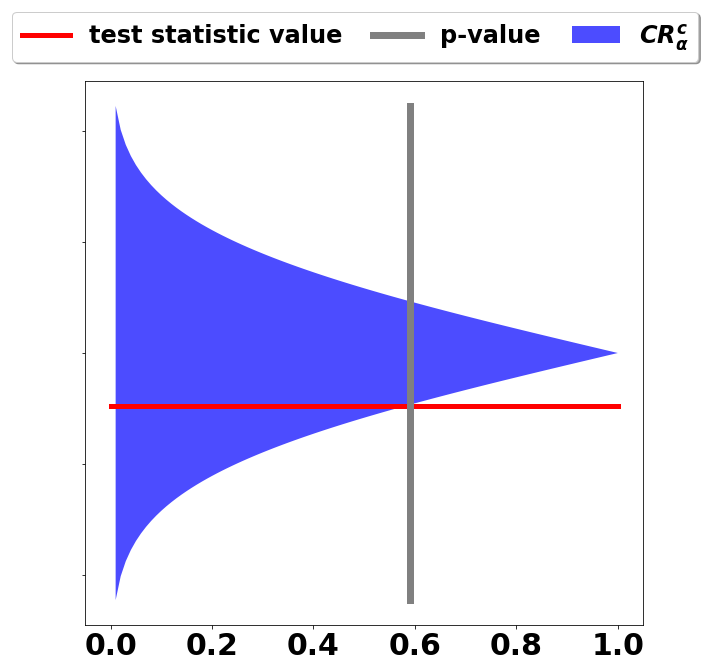

In [51]:
# illustration of the p-value, the statistic value and the critical region
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'legend.fontsize': 24})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.fill(np.concatenate([p, p[::-1]]),np.concatenate([threshold,(-threshold)[::-1]]),alpha=.7, fc='b', ec='None', label='$CR_{\\alpha}^{c}$')    
  
ax.set_yticklabels([])

plt.plot([0,1], [T,T], linewidth=5,color='r', label='test statistic value')
plt.plot([p_value, p_value], [-threshold[1], threshold[1]], linewidth=7, color='gray', label='p-value')

fig.legend(loc='upper left',ncol=5,mode="expand",shadow=True,fancybox=True)

(-1.2, 1.2, -1.2, 1.2)

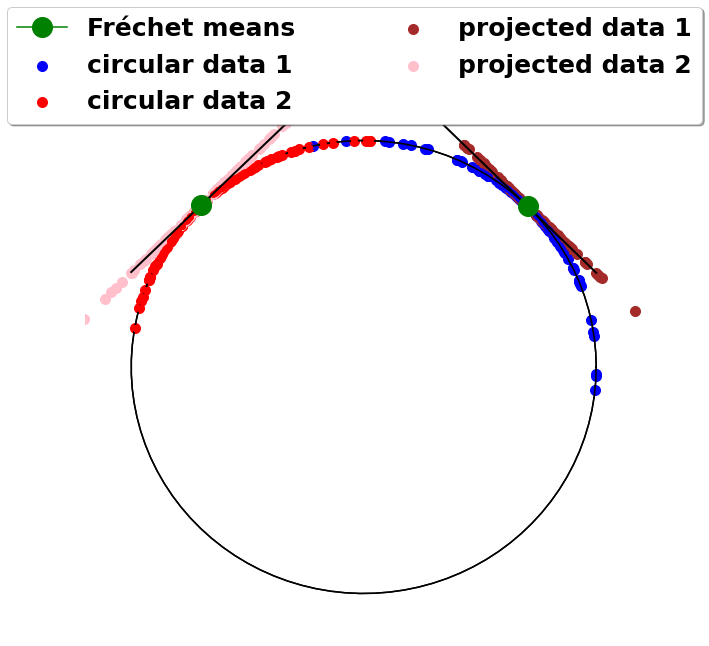

In [52]:
# illustration of some (here 100) circular data, their Fréchet means and their projections
import geomstats.visualization as visualization
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

sphere = Hypersphere(dim=1)

plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'legend.fontsize': 22})
plt.rcParams['font.weight'] = 'bold'

fig = plt.figure(figsize=(10, 10))

ax = visualization.plot(z1[0:99,:], space='S1', color='blue', alpha=0.7)
ax.scatter(z1[0:99,0], z1[0:99,1], color='blue', marker='o', s=100, label='circular data 1')

visualization.plot(z2[0:99,:], space='S1', color='red', ax=ax)
ax.scatter(z2[0:99,0], z2[0:99,1], color='red', marker='o', s=100, label='circular data 2')

t1=np.linspace(-1,1,20)

s1=(1-estimate_mean1[0]*t1)/estimate_mean1[1]
s2=(1-estimate_mean2[0]*t1)/estimate_mean2[1]

ax.plot(t1,s1,linewidth=2,color='black')
ax.plot(t1,s2,linewidth=2,color='black')


ax.scatter(x1[0:99,0], x1[0:99,1], color='brown', marker='o', s=100, label='projected data 1')
ax.scatter(x2[0:99,0], x2[0:99,1], color='pink', marker='o', s=100, label='projected data 2')


plt.plot(estimate_mean1[0,],estimate_mean1[1,], color='green', marker='o', markersize=20, label='Fréchet means')
plt.plot(estimate_mean2[0,],estimate_mean2[1,], color='green', marker='o', markersize=20)


fig.legend(loc='upper left', bbox_to_anchor=(0, 0.52, 1, 0.5), ncol=2,mode="expand",shadow=True,fancybox=True,fontsize="small")

plt.axis('off')